In [276]:
# Import Packages
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
from pandas.tseries.offsets import BDay
import numpy as np
import time
import os

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers

from sklearn.model_selection import train_test_split


# Top 100 S&P 500 Stocks - https://www.slickcharts.com/sp500
TICKERS = ['AAPL','MSFT','AMZN','FB','GOOGL','BRK.B','JNJ','V','PG',
           'JPM','NVDA','UNH','MA','HD','VZ','DIS','ADBE','CRM','NFLX',
          'PYPL','MRK','INTC','T','BAC','CMCSA','WMT','PFE','KO','PEP',
          'ABT','CSCO','XOM','TMO','ABBV','MCD','COST','CVX','ACN','AMGN',
          'AVGO','MDT','NKE','NEE','BMY','QCOM','LIN','UNP','TXN','LLY',
          'DHR','PM','LOW','HON','ORCL','UPS','AMT','C','IBM','SBUX',
          'AMD','MMM','LMT','WFC','BA','FIS','CHTR','RTX','BLK','INTU',
          'NOW','ISRG','SPGI','GILD','MDLZ','MO','CAT','CVS','BKNG','ZTS',
          'PLD','TGT','AXP','ANTM','VRTX','BDX','CCI','EQIX','TMUS','DE',
          'TJX','CI','D','CL','APD','GS','SYK','MS','ATVI','CME']

# Ticker to predict returns for
STOCK = 'AMZN'

# Set up hyperparameters for LSTM
BATCH_SIZE = 20
EPOCHS = 100
LR = 0.0001
TIMESTEPS = 30

In [3]:
# Load data from AlphaVantage
# AlphaVantage standard API call frequency is 5 calls per minute/500 calls per day
def getData(tickers, outputsize='full', sleep_time=60):
    
    """
        Get data for the tickers from prices.csv (if exists), otherwise pull data from AlphaVantage.
        
        tickers: list of stock symbols
        outputsize: compact (latest 100 data points), full (20+ years of historical data)
        sleep_time: seconds to sleep between API calls
        
        return: prices dataframe with date index sorted from high to low
    """
    
    temp = tickers
    tickers = set(tickers)
    
    ts = TimeSeries(key='ZEQZMDBKLXV2RQ53',output_format='pandas')
    cnt = 0
    
    if os.path.exists('prices.csv'):
        df = pd.read_csv('prices.csv')
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date',inplace=True)
        
        # If lastest date is not the most recent trading day, retrieve new data from AlphaVantage
        data, _ = ts.get_daily_adjusted(['AAPL'])
        cnt += 1
        
        if max(df.index) != max(data.index):
            df = pd.DataFrame()
        
        # Otherwise only update the missing tickers
        else:
            if tickers <= set(df.columns): # is subset
                return df[temp]
            else:
                tickers = tickers - set(df.columns) # add in the new tickers from AlphaVantage
    else:
        df = pd.DataFrame()
    
    print(f"{len(tickers)} tickers to retrieve from AlphaVantage, expected time: {sleep_time*((len(tickers)-1)//5)+10}s")
    
    
    for idx, t in enumerate(tickers):
        
        print(f"Retrieving ticker {idx+1}/{len(tickers)}...")
        
        # try/except to make sure we read in the data
        try:
            data, _ = ts.get_daily_adjusted(t,outputsize=outputsize)
        except:
            print(f"Waiting {sleep_time}s...")
            time.sleep(sleep_time)
            data, _ = ts.get_daily_adjusted(t,outputsize=outputsize)
        
        df[t] = data['5. adjusted close']
        cnt += 1
        if cnt and not cnt%5: # sleep every 5 calls
            print(f"Waiting {sleep_time}s...")
            time.sleep(sleep_time)
            
    df.to_csv('prices.csv')
    return df[temp]

df = getData(TICKERS)

In [283]:
# TODO: Add in technical indicators
# TODO: Traditional Time Series Methods (ARIMA, GARCH?, VAR?)

In [253]:
# Change from raw prices data to returns data with NAs dropped
def getReturns(df):
    
    """
        Change from raw prices data to returns data with NAs dropped
        
        df: prices dataframe with date index sorted from high to low
        
        return: returns dataframe with date index sorted from high to low
    """
    
    # Calculate log returns
    returns = np.log(df/df.shift(-1))
    # Drop columns with more than 1 NaNs (We need enough data to predict the returns)
    returns.dropna(axis=1,thresh=len(returns)-2,inplace=True)
    # Drop the last row (result of the returns calculation)
    returns.dropna(inplace=True)
    
    return returns

returns = getReturns(df)

In [74]:
# Turn returns into 3D tensors for input and 1D tensors for output
def buildTensors(df,ticker):
    """
        Turn returns into 3D tensors for inputs and 1D tensors for outputs for LSTM models.
        The total batch size would be reduced to a multiple of BATCH_SIZE
        
        df: returns dataframe with date index sorted from high to low
        ticker: stock symbol to be predicted
    
        return:
            inputs: 3D tensors of shape [batch, timesteps, feature]
            outputs: 1D tensor of shape [batch]
    """
    batch = (len(df) - TIMESTEPS)//BATCH_SIZE*BATCH_SIZE
    timesteps = TIMESTEPS
    feature = len(df.iloc[0])
    
    inputs = np.zeros((batch,timesteps,feature))
    outputs = np.zeros(batch)
    
    for i in range(batch):
        outputs[i] = df.iloc[i,df.columns.get_loc(ticker)]
        inputs[i] = df.iloc[i+1:i+1+timesteps]
    
    return inputs, outputs

In [228]:
# Build LSTM model
def buildLSTM(batch_size,timesteps,feature):
    """
        Build an LSTM model where input tensor shape is [batch, timesteps, feature]
        return: LSTM model
    """
    model = Sequential()
    # change return_sequences to True if multiple layers
    model.add(LSTM(50,batch_input_shape=(batch_size,timesteps,feature),
                  dropout=0.0,recurrent_dropout=0.0,stateful=True,return_sequences=True)) 
    model.add(Dropout(0.2))
    model.add(LSTM(20))
    model.add(Dropout(0.2))
    model.add(Dense(20,activation='relu'))
    model.add(Dense(1,activation=None)) # regression
    optimizer = optimizers.RMSprop(lr=LR)
    model.compile(loss='mse',optimizer=optimizer)
    return model

In [259]:
rTest.columns

Index(['AAPL', 'MSFT', 'AMZN', 'BRK.B', 'JNJ', 'PG', 'JPM', 'NVDA', 'UNH',
       'HD', 'VZ', 'DIS', 'ADBE', 'MRK', 'INTC', 'T', 'BAC', 'CMCSA', 'WMT',
       'PFE', 'KO', 'PEP', 'ABT', 'CSCO', 'XOM', 'TMO', 'MCD', 'COST', 'CVX',
       'AMGN', 'MDT', 'NKE', 'NEE', 'BMY', 'QCOM', 'UNP', 'TXN', 'LLY', 'DHR',
       'LOW', 'HON', 'ORCL', 'AMT', 'C', 'IBM', 'SBUX', 'AMD', 'MMM', 'LMT',
       'WFC', 'BA', 'RTX', 'BLK', 'INTU', 'GILD', 'MO', 'CAT', 'CVS', 'BKNG',
       'PLD', 'TGT', 'AXP', 'VRTX', 'BDX', 'CCI', 'DE', 'TJX', 'CI', 'D', 'CL',
       'APD', 'GS', 'SYK', 'MS', 'ATVI'],
      dtype='object')

In [279]:
# Split data into Train, Val, and Test sets
rTest, rTrain = train_test_split(returns,test_size=0.8,shuffle=False) # Note here test_size is actually train_size
# TODO: Walking forward Validation (Hyperparameter Tuning)
rTest, rVal = train_test_split(rTest,test_size=0.5,shuffle=False)
# TODO: Scaling the features
# Turn Train, Val, and Test data into inputs and outputs tensors
trainInputs, trainOutputs = buildTensors(rTrain,STOCK)
valInputs, valOutputs = buildTensors(rVal,STOCK)
testInputs, testOutputs = buildTensors(rTest,STOCK)
# Build LSTM model
model = buildLSTM(BATCH_SIZE, TIMESTEPS, len(trainInputs[0][0]))
# Add EarlyStopping
es = EarlyStopping(patience=40, min_delta=0.0001, mode='min')
# Add ModelCheckpoint
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
# Fit the model and record the callbakcs history
history = model.fit(trainInputs,trainOutputs,epochs=EPOCHS,verbose=2,batch_size=BATCH_SIZE,shuffle=False,
                    validation_data=(valInputs, valOutputs),callbacks=[es,mc])
# Predict stock returns
predOutputs = model.predict(testInputs,batch_size=BATCH_SIZE)

Epoch 1/100
208/208 - 4s - loss: 0.0012 - val_loss: 2.2032e-04
Epoch 2/100
208/208 - 3s - loss: 0.0012 - val_loss: 2.2238e-04
Epoch 3/100
208/208 - 3s - loss: 0.0012 - val_loss: 2.2944e-04
Epoch 4/100
208/208 - 3s - loss: 0.0012 - val_loss: 2.2247e-04
Epoch 5/100
208/208 - 3s - loss: 0.0012 - val_loss: 2.2455e-04
Epoch 6/100
208/208 - 3s - loss: 0.0012 - val_loss: 2.3018e-04
Epoch 7/100
208/208 - 3s - loss: 0.0012 - val_loss: 2.2097e-04
Epoch 8/100
208/208 - 3s - loss: 0.0012 - val_loss: 2.2599e-04
Epoch 9/100
208/208 - 3s - loss: 0.0012 - val_loss: 2.2409e-04
Epoch 10/100
208/208 - 3s - loss: 0.0012 - val_loss: 2.2525e-04
Epoch 11/100
208/208 - 3s - loss: 0.0012 - val_loss: 2.2248e-04
Epoch 12/100
208/208 - 3s - loss: 0.0012 - val_loss: 2.2604e-04
Epoch 13/100
208/208 - 3s - loss: 0.0012 - val_loss: 2.2617e-04
Epoch 14/100
208/208 - 3s - loss: 0.0012 - val_loss: 2.3724e-04
Epoch 15/100
208/208 - 3s - loss: 0.0012 - val_loss: 2.2561e-04
Epoch 16/100
208/208 - 3s - loss: 0.0012 - val_lo

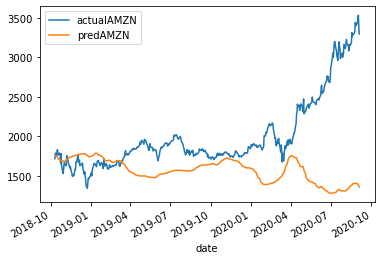

In [280]:
# Results visualization
def plotResults():
    """
        Plot actual vs. predicted prices.
        Note the prices predictions are not readjusted to previous day's level.
        So we are able to view the cumulative differences.
        
    """
    plotData = pd.DataFrame(rTest[STOCK])
    plotData['price'] = df[STOCK]
    idx = plotData.index
    plotData.reset_index(drop=True, inplace=True)
    toAdd1 = pd.DataFrame({'testOutputs':testOutputs})
    toAdd2 = pd.DataFrame({'predOutputs':predOutputs.flatten()})
    plotData = pd.concat([plotData,toAdd1,toAdd2],axis=1)
    plotData.set_index(idx,inplace=True)
    plotData.dropna(inplace=True)

    plotData = plotData.iloc[::-1] # reverse the index, now date is ascending

    plotData[f'actual{STOCK}'] = plotData['price'][0]*(np.exp(plotData['testOutputs'][1:].cumsum()))
    plotData[f'pred{STOCK}'] = plotData['price'][0]*(np.exp(plotData['predOutputs'][1:].cumsum()))
    plotData = plotData[[f'actual{STOCK}',f'pred{STOCK}']]
    plotData.plot()

plotResults()

In [281]:
# TODO: Backtest Strategy

I came across many research papers and online articles claiming that their models were able to predict the stock market. To me, it seemed obvious that many of these are invalid claims.

There are multiple mistakes that could be made:
1. Leaking test data into the training data
2. Building the model on prices (depending on how the model is actually built, be careful about non-stationarity and spurious regression)
3. One-day forecasting. The predicted price and the actual price usually align super well but in fact it's not too much better than just shifting the entire graph forward by one-day. New price predictions are usually just some (random) predicted movements added to the prior day's price level. 

The model could be better tuned to (maybe) make better predictions, but at least there are few things we need to clearly think through before just tuning the hyperparameters:
1. Reflexivity
2. Signal-to-Noise Ratio (With the limited amount of data we have, can we really find the signals out of the noises? Also, what is really the noise given the strong reflexivity in the stock market? If there's a pattern/defined rule/hidden distribution that stays true, machine learning methods might be able to identify the pattern given enough data. But if the underlying itself keeps changing and is so dynamic, and is affected by the participants, other ideas (behaviour finance?) might need to be introduced.) 
3. Regime Switch
4. Data Availability